In [1]:
cd ..

/media/hjp/FAAC278CAC27430D/HJP/KUAICV/Hand/AbsoluteTrack


In [2]:
pwd

'/media/hjp/FAAC278CAC27430D/HJP/KUAICV/Hand/AbsoluteTrack'

In [11]:
import numpy as np
import cv2
import os
import json
import matplotlib.pyplot as plt



from lib.common.camera import Fisheye62CameraModel
from lib.common.hand import HandModel
from lib.tracker.tracking_result import SingleHandPose
from lib.tracker.video_pose_data import (
    HandPoseLabels,
    _load_hand_pose_labels,
    load_hand_model_from_dict,
    
)
from lib.tracker.perspective_crop import landmarks_from_hand_pose


HAND_CONNECTION_MAP = [
    [5, 6], [6, 7], [7, 0], # thumb
    [5, 8], [8, 9], [9, 10], [10, 2], # index
    [5, 11], [11, 12], [12, 13], [13, 2], # middle
    [5, 14], [14, 15], [15, 16], [16, 3], # ring
    [5, 17], [17, 18], [18, 19], [19, 4], # pinky
    [8, 11], [11, 14], [14, 17]
]
gt_handedness_color_map = {
    0: (0, 0, 255), # RED
    1: (0, 255, 0), # GREEN
}

UMETRACK_ROOT = "."
SAMPLE_VID_PATH = os.path.join(UMETRACK_ROOT, "sample_data/user05/recording_00.mp4")
SAMPLE_LABEL_PATH = os.path.join(UMETRACK_ROOT, "sample_data/user05/recording_00.json")
RESULT_FILE__PATH = os.path.join(UMETRACK_ROOT, "sample_data/user05/recording_00.npy")

cap = cv2.VideoCapture(SAMPLE_VID_PATH)
n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)) // 4
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

frame_list = []
stereo_bgr_frame_list = []
stereo_mono_frame_list = []
for frame_idx in range(n_frames) :
    ret, frame = cap.read()
    if ret :
        frame_list.append(frame)
        stereo_bgr_frame_list.append([
            frame[:, :frame_width], 
            frame[:, frame_width:frame_width*2],
            frame[:, frame_width*2:frame_width*3],
            frame[:, frame_width*3:]
        ])
        frame_mono = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        stereo_mono_frame_list.append([
            frame_mono[:, :frame_width],
            frame_mono[:, frame_width:frame_width*2],
            frame_mono[:, frame_width*2:frame_width*3],
            frame_mono[:, frame_width*3:]
        ])
    else :
        break

stereo_bgr_frame_array = np.array(stereo_bgr_frame_list)
stereo_mono_frame_array = np.array(stereo_mono_frame_list)

print(n_frames, frame_width, frame_height)

data = _load_hand_pose_labels(SAMPLE_LABEL_PATH)
hand_model = data.hand_model

result = np.load(RESULT_FILE__PATH, allow_pickle=True)

451 636 480


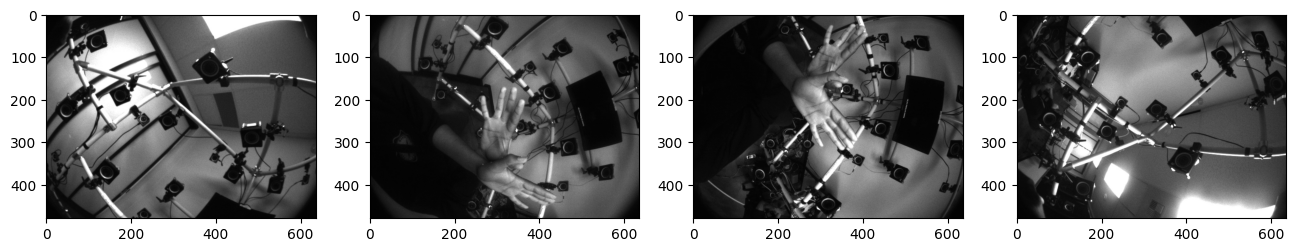

In [15]:
FRAME_IDX = 20

plt.figure(figsize=(16, 4))
for i in range(4) :
    plt.subplot(1, 4, i+1)
    plt.imshow(stereo_bgr_frame_array[FRAME_IDX, i])
plt.show()

In [ ]:
result['tracked_keypoints'].shape


(2, 451, 21, 3)

In [13]:
result['tracked_keypoints'][0, 0]

array([[ 68.71844482, 216.58332825,  40.13854599],
       [-11.98468781, 161.07789612, 108.47898102],
       [-23.72966003, 155.16947937, 119.86988068],
       [-19.80744934, 136.58895874, 117.69519806],
       [ -7.62844849, 136.80696106, 130.65811157],
       [ 43.3073349 ,  75.31613159,  71.4265976 ],
       [ 44.92275238, 163.59867859,  50.53870392],
       [ 57.72614288, 196.10232544,  36.35299301],
       [ 64.09867859, 171.76779175, 106.67685699],
       [ 30.28094482, 188.15206909, 124.66740417],
       [  6.60054016, 174.8031311 , 115.16197968],
       [ 70.63500214, 156.93060303, 124.3392334 ],
       [ 28.96800995, 172.66891479, 138.9150238 ],
       [  0.46417236, 162.97392273, 129.10809326],
       [ 67.53630066, 139.15878296, 138.42314148],
       [ 26.42121887, 152.40101624, 145.9372406 ],
       [  0.62641907, 145.10455322, 132.802948  ],
       [ 58.95023346, 119.07662964, 148.70455933],
       [ 31.16179657, 135.6569519 , 154.88796997],
       [ 12.10331726, 135.86346

In [12]:
data.camera_to_world_transforms.shape

(451, 4, 4, 4)

In [7]:
for frame_idx in range(int(cap.get(cv2.CAP_PROP_FRAME_COUNT))):
    gt_tracking = {}
    for hand_idx in range(0, 2):
        if data.hand_confidences[frame_idx, hand_idx] > 0:
            gt_tracking[hand_idx] = SingleHandPose(
                joint_angles=data.joint_angles[frame_idx, hand_idx],
                wrist_xform=data.wrist_transforms[frame_idx, hand_idx],
                hand_confidence=data.hand_confidences[frame_idx, hand_idx]
            )

In [8]:
print(frame_width, frame_height)

636 480


(480, 2544, 3)


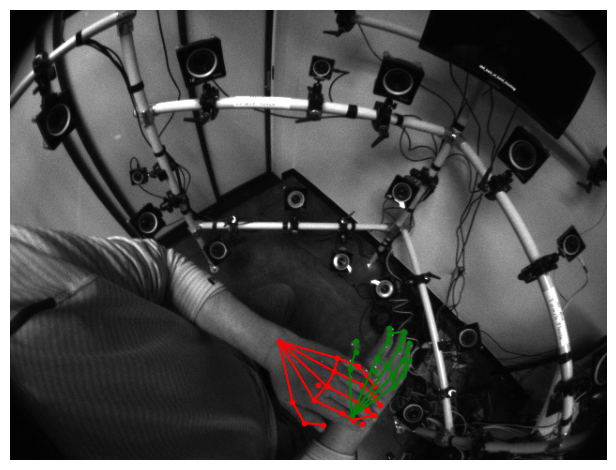

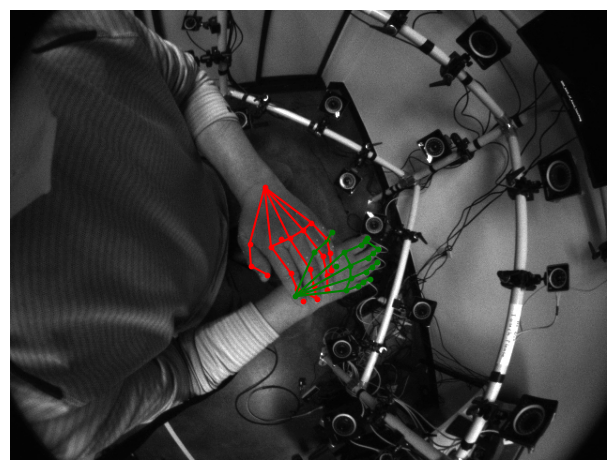

In [10]:
FRAME_IDX = 20

gt_handedness_color_map = {
    0: 'red',  # RED
    1: 'green',  # GREEN
}

cap.set(cv2.CAP_PROP_POS_FRAMES, FRAME_IDX)
ret, frame_stereo = cap.read()

print(frame_stereo.shape)

cam_left = data.cameras[1].copy(
    camera_to_world_xf=data.camera_to_world_transforms[FRAME_IDX, 1]
)
cam_right = data.cameras[2].copy(
    camera_to_world_xf=data.camera_to_world_transforms[FRAME_IDX, 2]
)

frame_left_mono = frame_stereo[:, frame_width : 2*frame_width].copy()
frame_right_mono = frame_stereo[:, frame_width*2 : frame_width*3].copy()

gt_tracking = {}
for hand_idx in range(0, 2):
    if data.hand_confidences[FRAME_IDX, hand_idx] > 0:
        gt_tracking[hand_idx] = SingleHandPose(
            joint_angles=data.joint_angles[FRAME_IDX, hand_idx],
            wrist_xform=data.wrist_transforms[FRAME_IDX, hand_idx],
            hand_confidence=data.hand_confidences[FRAME_IDX, hand_idx]
        )

window_hand_pose_left = {}
for hand_idx in range(0, 2):
    keypoints_world = landmarks_from_hand_pose(
        hand_model,
        gt_tracking[hand_idx],
        hand_idx
    )
    window_hand_pose_left[hand_idx] = cam_left.eye_to_window(
        cam_left.world_to_eye(keypoints_world)
    )

window_hand_pose_right = {}
for hand_idx in range(0, 2):
    keypoints_world = landmarks_from_hand_pose(
        hand_model,
        gt_tracking[hand_idx],
        hand_idx
    )
    window_hand_pose_right[hand_idx] = cam_right.eye_to_window(
        cam_right.world_to_eye(keypoints_world)
    )

plt.imshow(frame_left_mono)
for hand_idx in range(0, 2):
    # plot points
    plt.scatter(
        window_hand_pose_left[hand_idx][:, 0],
        window_hand_pose_left[hand_idx][:, 1],
        marker='o',
        color=gt_handedness_color_map[hand_idx],
        s=10
    )
    # plot connections
    for connection in HAND_CONNECTION_MAP:
        plt.plot(
            window_hand_pose_left[hand_idx][connection, 0],
            window_hand_pose_left[hand_idx][connection, 1],
            color=gt_handedness_color_map[hand_idx],
        )
plt.axis('off')
plt.tight_layout()
plt.show()


plt.imshow(frame_right_mono)
for hand_idx in range(0, 2):
    # plot points
    plt.scatter(
        window_hand_pose_right[hand_idx][:, 0],
        window_hand_pose_right[hand_idx][:, 1],
        marker='o',
        color=gt_handedness_color_map[hand_idx],
        s=10
    )
    # plot connections
    for connection in HAND_CONNECTION_MAP:
        plt.plot(
            window_hand_pose_right[hand_idx][connection, 0],
            window_hand_pose_right[hand_idx][connection, 1],
            color=gt_handedness_color_map[hand_idx],
        )
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
UMETRACK_ROOT = "."
DATA_PATH = os.path.join(UMETRACK_ROOT, "sample_data/user05/recording_02.mp4")

: 